In [12]:
from models import *
from load import *
from torch import Tensor, nn
import torch
import matplotlib.pyplot as plt
from models_base import Dataset, get_device
from modules import NormalizedPoissonRMSE, PoissonVAE

ROOT = "./Datas/Week 7"

class Progress:
    def __init__(self, pad = 200):
        self.pad = pad
    
    def rint(self, content: str):
        print(content.ljust(self.pad), end = '\r')
        self.pad = max(self.pad, len(content) + 1)

Q = 1.60217663e-19

def init_weights(m):
    try:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    except AttributeError:
        pass

def load():
    ep = Dataset(load_elec_potential())
    sc = Dataset(load_space_charge() * (-Q))
    epsc = (ep + sc).clone().to_tensor().reshape(-1, 4386)
    return epsc

def train(epochs: int, latent: int = 5):
    noise_ = 0.01
    device = get_device()
    net = PoissonVAE(latent).to(device).double()
    net.apply(init_weights)
    history = []
    mse = nn.MSELoss()
    poi = NormalizedPoissonRMSE()
    epsc = load().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    p = Progress()

    for epoch in range(epochs):
        # Add some noise
        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()

            x = epsc
            noisy_x = x + (torch.rand((1, 4386)) - 1/2).to(device).double() * noise_
            x_hat = net(noisy_x)
            mse_loss_ep = mse(x[:, :2193], x_hat[:, :2193])
            mse_loss_sc = mse(x[:, 2193:], x_hat[:, 2193:])
            poi_loss = poi(x_hat[:, :2193], x_hat[:, 2193:])
            kl_diver = net.get_kl_divergence()
            loss = mse_loss_ep + mse_loss_sc + poi_loss + kl_diver
            if loss.requires_grad:
                loss.backward()

            nonlocal history
            history.append([mse_loss_ep.item(), mse_loss_sc.item(), poi_loss.item(), kl_diver.item()])

            nonlocal p
            mse1_, mse2_, poi_, kl_ = history[-1]
            p.rint(f"Elapsed {epoch} epochs with MSE: {mse1_:.7f}, {mse2_:.7f}, Poisson: {poi_:.7f}, KL divergence: {kl_:.7f}")

            return loss
        optimizer.step(closure)

        mse1_, mse2_, poi_, kl_ = history[-1]
        if poi_ < 0.01 and kl_ < 0.01:
            break
    return net, history

net, history = train(90000)

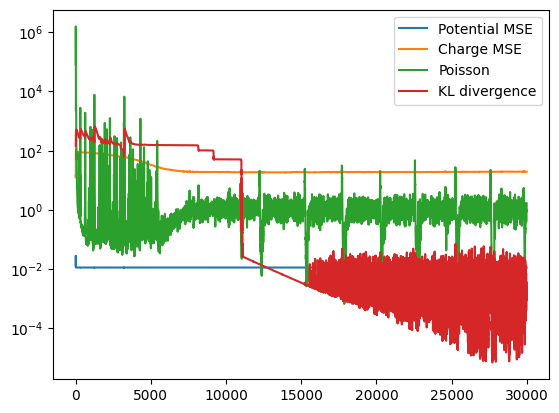

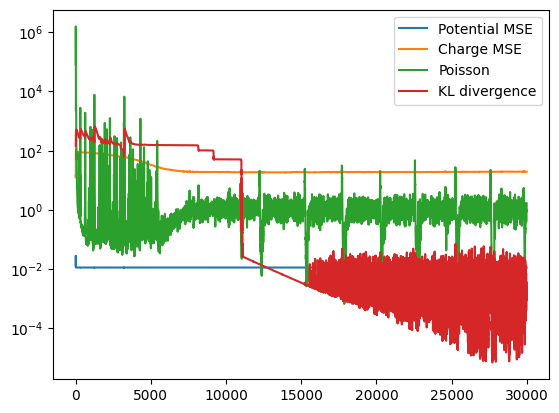

In [16]:
from anim import make_anim

training_model_no = 1

plt.figure()
plt.plot(history[::])
plt.yscale('log')
plt.legend(["Potential MSE", "Charge MSE", "Poisson", "KL divergence"])
plt.savefig(f"./model {training_model_no} results.png")

torch.save(net, f"./model {training_model_no}.pt")

device = get_device()

Q = 1.60217663e-19
ep = Dataset(load_elec_potential())
sc = Dataset(load_space_charge() * (-Q))
epsc = (ep + sc).clone().to_tensor().reshape(-1, 4386)
x = epsc.to(device)
with torch.no_grad():
    y = net(x)
    y_ep = y[:, :2193].reshape(-1, 129, 17).cpu().numpy()
    y_sc = y[:, 2193:].reshape(-1, 129, 17).cpu().numpy()
    ep = load_elec_potential().cpu().numpy()
    sc = load_space_charge().cpu().numpy() * -Q
    make_anim(y_ep, ep, f"./potential training {training_model_no}.gif", "Potential")
    make_anim(y_sc, sc, f"./spacecharge training {training_model_no}.gif", "Space charge")

